# Importing the libraries

In [164]:
import pixellib
from pixellib.semantic import semantic_segmentation
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
import PIL
import PIL.Image
from skimage.transform import resize

# Load the pretrained Deeplabv3+ on ADE20K

In [3]:
segment_image = semantic_segmentation()
segment_image.load_ade20k_model("deeplabv3_xception65_ade20k.h5")

2022-11-12 14:45:29.671844: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Defining functions

In [4]:
def IoU_coeff(y_true, y_pred):
    axes = (0,1) 
    intersection = np.sum(np.abs(y_pred * y_true), axis=axes) 
    mask = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
    union = mask - intersection
    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Testing on one image

In [160]:
##segment an image
img = plt.imread("/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person/people_segmentation/images/young-girl-ballerina-dance-591679.jpg")
plt.imsave('/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person/people_segmentation/im.jpg',resize(img, (128,128)))
segmap, seg_overlay = segment_image.segmentAsAde20k('/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person/people_segmentation/im.jpg', overlay = False)
# cv2.imwrite("/home/mohamed.boudjoghra/assignements/AI701/project/prediction/img.jpg", seg_overlay)

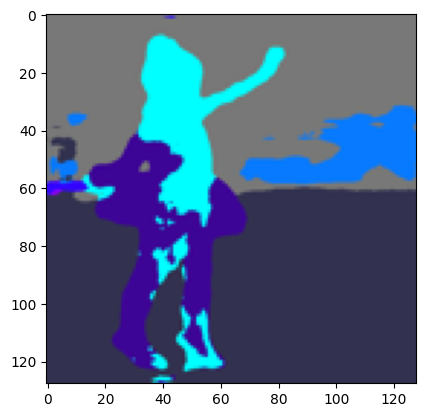

In [161]:
plt.imshow(seg_overlay)

In [162]:

## getting the prediction
person_mask = np.zeros(seg_overlay.shape)
person_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
person_mask=np.average(person_mask, axis = 2)
person_mask*=(1.0/np.amax(person_mask))

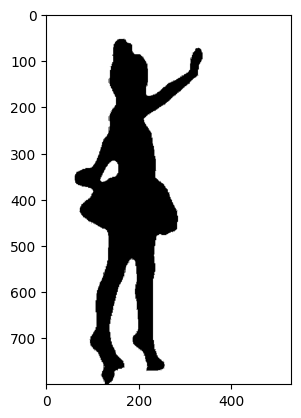

In [154]:

plt.imshow(person_mask,cmap = plt.cm.binary)

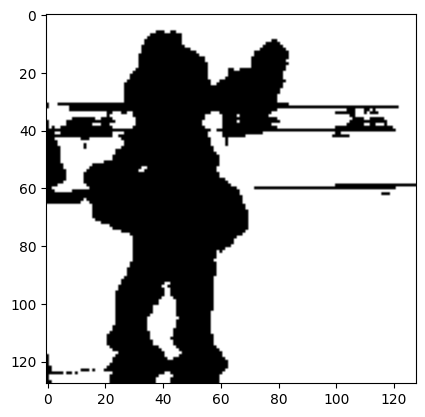

In [146]:
path = '/home/mohamed.boudjoghra/Downloads/prediction.png'
person_mask = plt.imread(path,0)[:,:,0]

plt.imshow(person_mask,cmap = plt.cm.binary)

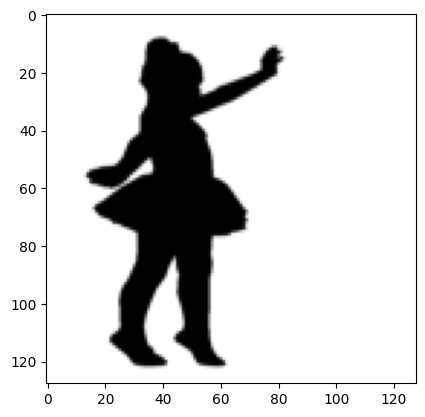

In [152]:
path = r'/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person/people_segmentation/masks/young-girl-ballerina-dance-591679.png' 
# Using cv2.imread() method
ground_truth = cv2.imread(path, 0)
ground_truth=np.float64(ground_truth)*(1.0/np.amax(ground_truth))
ground_truth=resize(ground_truth, (128,128))
plt.imshow(ground_truth,cmap = plt.cm.binary)

In [147]:
IoU_coeff(ground_truth, person_mask) ## Testing if the function works

0.38289870963033185

In [163]:
IoU_coeff(person_mask, ground_truth)  ##Getting the IoU of the tested image

0.33035823538709086

# Getting the test IoU of the person dataset

In [11]:
##defining the paths
data_path  ='/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person/people_segmentation/'

folders = ['images', 'masks', 'predictions']

## creating the directories
Images_dir = os.path.join(data_path, folders[0])
Masks_dir = os.path.join(data_path, folders[1])
Predictions_dir = os.path.join(data_path, folders[2])

In [12]:
Images_list = sorted(os.listdir(Images_dir)) ## getting the list of images inside the directory
Masks_list = sorted(os.listdir(Masks_dir))  ## getting the list of masks inside the directory

In [13]:
##Checking the number of images and masks
print(f"There are {len(Images_list)} images in the folder {folders[0]}")
print(f"There are {len(Masks_list)} images in the folder {folders[1]}")

There are 5678 images in the folder images
There are 5678 images in the folder masks


In [ ]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names']:
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0
    iou += iou_img

    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

# testing the model on the ocludded data set

In [122]:
##defining the paths
occ_data_path  ='/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person_occluded/occluded_dataset/'
data_path  ='/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person/people_segmentation/'

Img_folders = ['a=0.005', 
           'a=0.01',
           'a=0.05',
           'a=0.1',
           'a=0.5',
            'a=1']
Prediction_folders = [
           'predictions_a=0.005', 
           'predictions_a=0.01',
           'predictions_a=0.05',
           'predictions_a=0.1',
           'predictions_a=0.5',
            'predictions_a=1']


## a = 0.005

In [99]:
## creating the directories
Images_dir = os.path.join(occ_data_path, Img_folders[0])
Masks_dir = os.path.join(data_path, 'masks')
Predictions_dir = os.path.join(occ_data_path, Prediction_folders[0])

In [ ]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names']:
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0
    iou += iou_img

    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

## a = 0.01

In [125]:
## creating the directories
Images_dir = os.path.join(occ_data_path, Img_folders[1])
Masks_dir = os.path.join(data_path, 'masks')
Predictions_dir = os.path.join(occ_data_path, Prediction_folders[1])

In [ ]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names']:
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0
    iou += iou_img

    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

## a = 0.05

In [101]:
## creating the directories
Images_dir = os.path.join(occ_data_path, Img_folders[2])
Masks_dir = os.path.join(data_path, 'masks')
Predictions_dir = os.path.join(occ_data_path, Prediction_folders[2])

In [ ]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names']:
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0
    iou += iou_img

print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

## a = 0.1

In [103]:
## creating the directories
Images_dir = os.path.join(occ_data_path, Img_folders[3])
Masks_dir = os.path.join(data_path, 'masks')
Predictions_dir = os.path.join(occ_data_path, Prediction_folders[3])

In [ ]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names']:
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0
    iou += iou_img

    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

## a = 0.5

In [107]:
## creating the directories
Images_dir = os.path.join(occ_data_path, Img_folders[4])
Masks_dir = os.path.join(data_path, 'masks')
Predictions_dir = os.path.join(occ_data_path, Prediction_folders[4])

In [ ]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names'] and np.any(seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay]):
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0  
    iou += iou_img
    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

## a = 1

In [123]:
## creating the directories
Images_dir = os.path.join(occ_data_path, Img_folders[5])
Masks_dir = os.path.join(data_path, 'masks')
Predictions_dir = os.path.join(occ_data_path, Prediction_folders[5])

In [ ]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder
i = 1
iou = 0
if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)
        
for (img_name, mask_name) in zip(Images_list, Masks_list):
    print("-----------------------------------------------------------------------")
    print(f"Testing image {i}")
    img_dir = os.path.join(Images_dir, f"{img_name}")
    segmap, seg_overlay = segment_image.segmentAsAde20k(img_dir, overlay = False)
    ## getting the prediction
    if 'person' in segmap['class_names'] and np.any(seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay]):
        predicted_mask = np.zeros(seg_overlay.shape)
        predicted_mask[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay] = seg_overlay[np.array(segmap['class_colors'])[np.array(segmap['class_names'])=='person']==seg_overlay][0]
        predicted_mask=np.average(predicted_mask, axis = 2)
        predicted_mask*=(1.0/np.amax(predicted_mask))
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), predicted_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, predicted_mask)
    else:
        iou_img = 0  
    iou += iou_img
    
print(f"The average IoU score for this testset is {iou/len(Images_list)}") 